# Response matrices

In [1]:
import at
import numpy as np
import math
from pathlib import Path
from importlib.resources import files, as_file

In [2]:
with as_file(files("machine_data") / "hmba.mat") as path:
    hmba_lattice = at.load_lattice(path)

In [3]:
for sx in hmba_lattice.select(at.Sextupole):
    sx.KickAngle=[0,0]
hmba_lattice.enable_6d()

In [4]:
ring = hmba_lattice.repeat(8)

A {py:class}`.ResponseMatrix` object defines a general-purpose response matrix, based
on a {py:class}`.VariableList` of attributes which will be independently varied, and an
{py:class}`.ObservableList` of attributes which will be recorded for each
variable step.

{py:class}`.ResponseMatrix` objects can be combined with the "+" operator to define
combined responses. This concatenates the variables and the observables.

This module also defines two commonly used response matrices:
{py:class}`.OrbitResponseMatrix` for circular machines and
{py:class}`.TrajectoryResponseMatrix` for beam lines. Other matrices can be easily
defined by providing the desired Observables and Variables to the
{py:class}`.ResponseMatrix` base class.

## Instantiation

The simplest orbit response matrix can be instantiated with:

In [ ]:
resp_v = at.OrbitResponseMatrix(ring, "v")

By default, the observables are all the {py:class}`.Monitor` elements, and the
variables are all the elements having a *KickAngle* attribute. This is equivalent to:
```python
resp_v = at.OrbitResponseMatrix(ring, "v", bpmrefs = at.Monitor,
                             steerrefs = at.checkattr("KickAngle"))
```
If correction is desired, the variable elements must have the *KickAngle* attribute
used for correction. It's available for all magnets, though not present by default
except in {py:class}`.Corrector` magnets. For other magnets, the attribute should be
explicitly created.

There are options to include the RF frequency in the variable list, and the sum of
correction angles in the list of observables:

In [5]:
resp_h = at.OrbitResponseMatrix(ring, "h", cavrefs=at.RFCavity, steersum=True)
print(resp_h.shape)

(81, 49)


A combined horizontal+vertical response matrix can be obtained with:
```python
resp_hv = resp_h + resp_v
```

## Matrix Building

The response matrix may be built by two methods:

1. {py:meth}`~.ResponseMatrix.build` computes the matrix using tracking.
2. {py:meth}`~.ResponseMatrix.load` loads data from a file containing previously
   saved values or experimentally measured values

In [6]:
resp_h.build(use_mp=True, start_method='fork')

## Normalisation

To be correctly inverted, the response matrix must be correctly normalised: the norms
of its columns must be of the same order of magnitude, and similarly for the rows.
This is done by adjusting the weights {math}`w_v` for the variables {math}`\mathbf{V}`
and {math}`w_o` for the observables {math}`\mathbf{O}`.
With {math}`\mathbf{R}` the response matrix:

:::{math}

   \mathbf{O} = \mathbf{R} . \mathbf{V}
:::

The weighted response matrix {math}`\mathbf{R}_w` is:

:::{math}

   \frac{\mathbf{O}}{w_o} = \mathbf{R}_w . \frac{\mathbf{V}}{w_v}
:::
The {math}`\mathbf{R}_w` is dimensionless and should be normalised. This can be checked
using:

* {py:meth}`~.ResponseMatrix.check_norm` which prints the ratio of the maximum / minimum
  norms for variables and observables. These should be less than 10.
* {py:meth}`~.ResponseMatrix.plot_norm`

Both natural and weighted response matrices can be retrieved with the
{py:meth}`~.ResponseMatrix.get_response` method.

In [7]:
resp_h.cavdelta=300

max/min Observables: 14.684636088923144
max/min Variables: 2.9487976421845206


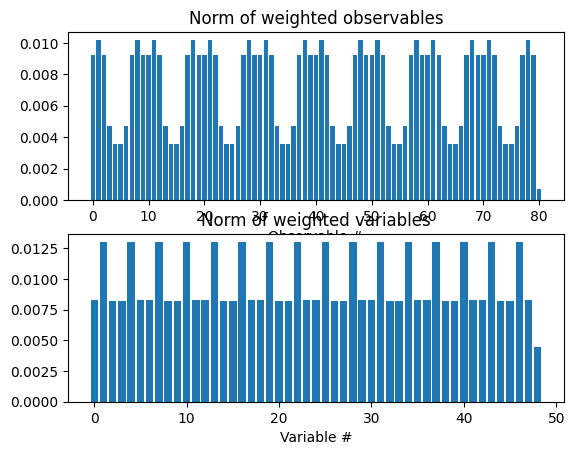

In [8]:
resp_h.plot_norm()

## Inversion

The {py:meth}`~.ResponseMatrix.solve` method computes the singular values of the
weighted response matrix.

In [ ]:
resp_h.solve()

We can plot the singular values:

In [ ]:
resp_h.plot_singular_values()

After solving, orbit correction is available, for instance with

* {py:meth}`~.ResponseMatrix.get_correction` which returns the correction matrix,
* {py:meth}`~.ResponseMatrix.correct` which computes and optionally applies a correction
  for the provided {py:class}`.Lattice`.

In [ ]:
resp_h.shape